In [1]:
using Distributions
using StatsPlots
using Turing
using Logging
using LaTeXStrings

default(labels=false)

# Code 2.1

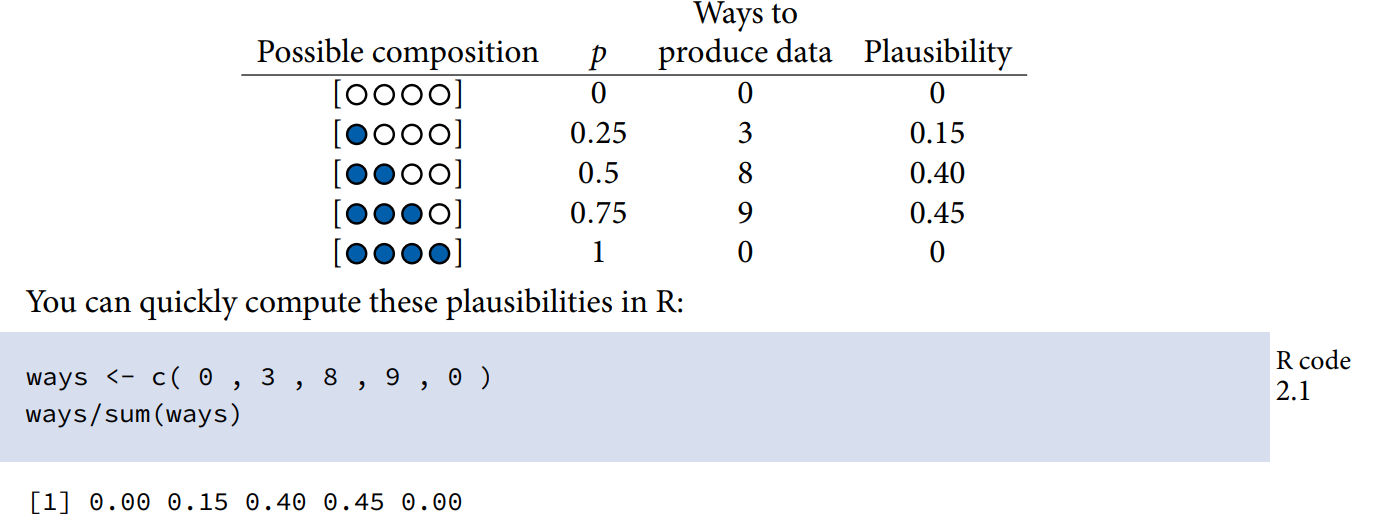

In [2]:
ways = [0, 3, 8, 9, 0]
ways = ways ./ sum(ways)
println(ways)

[0.0, 0.15, 0.4, 0.45, 0.0]


# Code 2.2

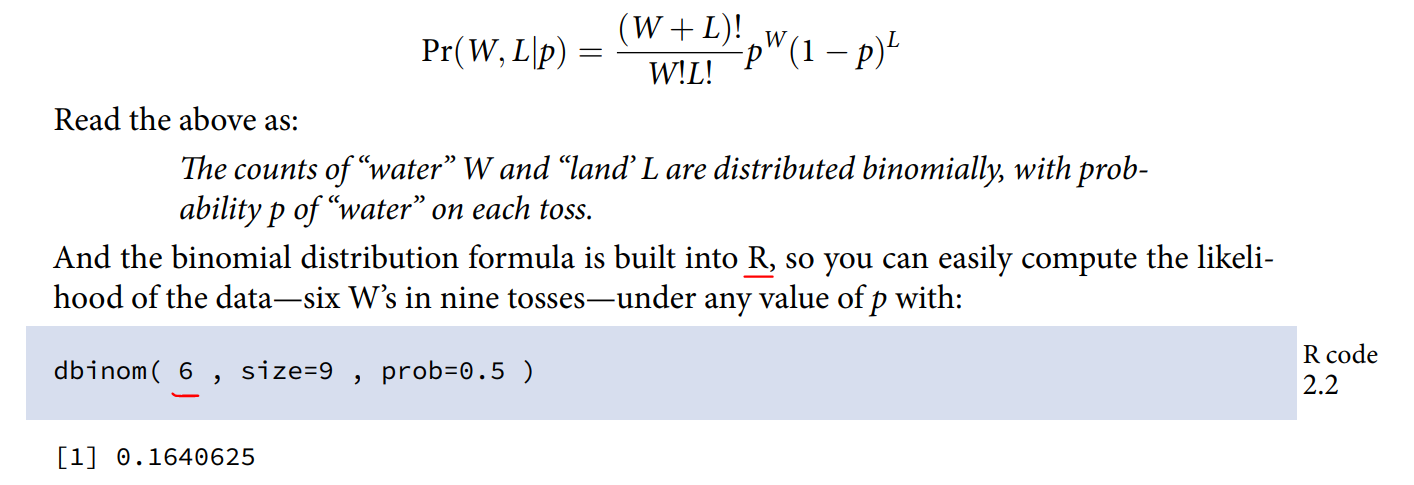

In [3]:
b = Binomial(9, 0.5)
pdf(b, 6)

0.16406250000000056

# Code 2.3

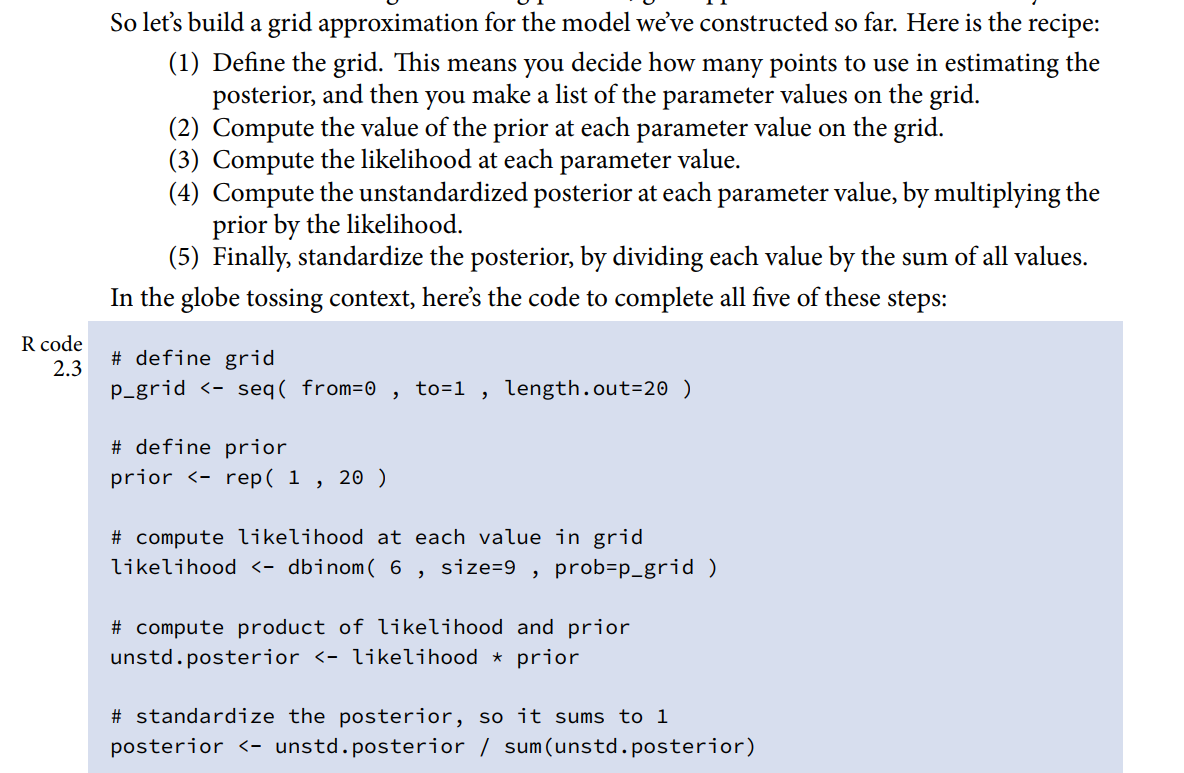

In [4]:
# size of the grid
size = 20

# grid and prior
p_grid = range(0, 1; length=size)
prior = repeat([1.0], size)

# compute likelihood at each value in grid
likelyhood = [pdf(Binomial(9, p), 6) for p in p_grid]

# compute product of likelihood and prior
unstd_posterior = likelyhood .* prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / sum(unstd_posterior);

# Code 2.4

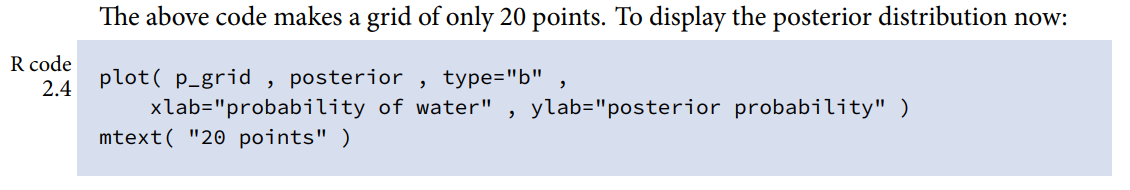

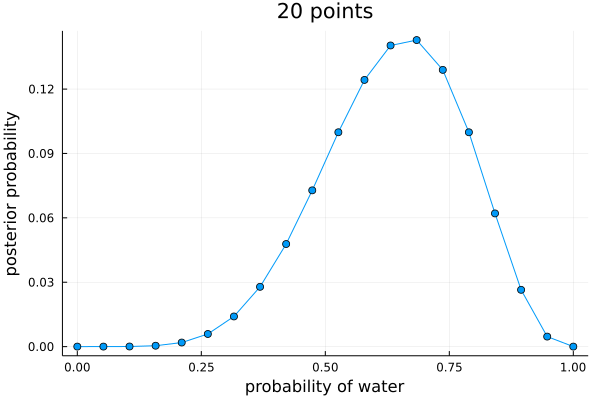

In [5]:
plot(p_grid, posterior; 
    xlabel="probability of water", 
    ylabel="posterior probability",
    title="$size points",
    markershape=:circle
)

# Code 2.5

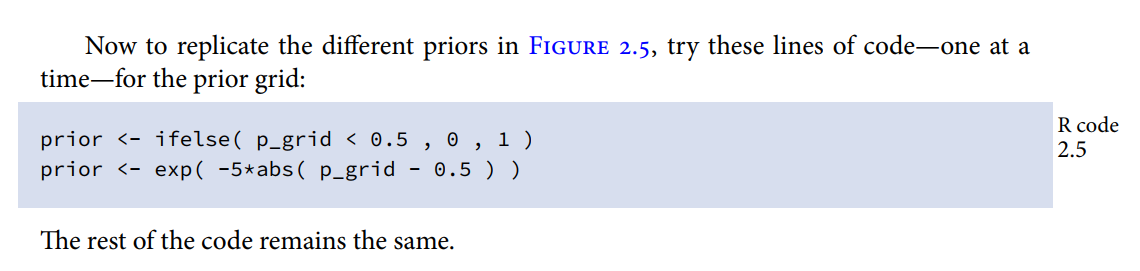

In [9]:
tt=range(0, 1; length=size)
typeof(tt)

StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

In [10]:
tt1=vec(tt)
typeof(tt1)

StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

In [11]:
tt2=convert(Vector{AbstractFloat}, tt)  # using convert

20-element Vector{AbstractFloat}:
 0.0
 0.05263157894736842
 0.10526315789473684
 0.15789473684210525
 0.21052631578947367
 0.2631578947368421
 0.3157894736842105
 0.3684210526315789
 0.42105263157894735
 0.47368421052631576
 0.5263157894736842
 0.5789473684210527
 0.631578947368421
 0.6842105263157895
 0.7368421052631579
 0.7894736842105263
 0.8421052631578947
 0.8947368421052632
 0.9473684210526315
 1.0

In [12]:
tt2 .>0.5

20-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

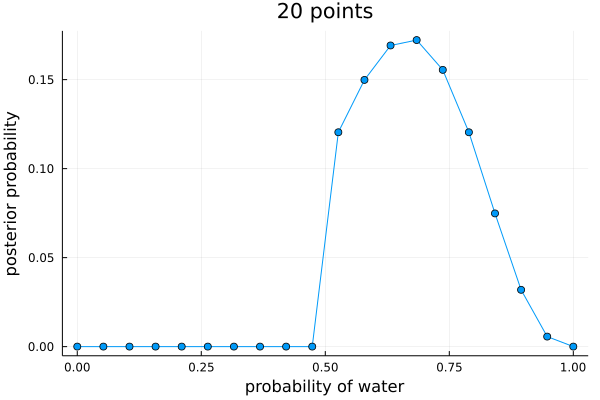

In [6]:
size = 20
p_grid = range(0, 1; length=size)

# prior is different - 0 if p < 0.5, 1 if >= 0.5
prior = convert(Vector{AbstractFloat}, p_grid .>= 0.5)

# another prior to try (uncomment the line below)
# prior = exp.(-5*abs.(p_grid .- 0.5))

# the rest is the same
likelyhood = [pdf(Binomial(9, p), 6) for p in p_grid]
unstd_posterior = likelyhood .* prior
posterior = unstd_posterior / sum(unstd_posterior);

plot(p_grid, posterior; 
    xlabel="probability of water", 
    ylabel="posterior probability",
    title="$size points",
    markershape=:circle
)

# Code 2.6

In [14]:
@model function water_land(W, L)
    p ~ Uniform(0, 1)
    W ~ Binomial(W + L, p)
end

Logging.disable_logging(Logging.Warn)
chain = sample(water_land(6, 3), NUTS(0.65), 1000)
display(chain)

Chains MCMC chain (1000×13×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 7.9 seconds
Compute duration  = 7.9 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           p    0.6413    0.1406     0.0044    0.0057   645.0785    1.0002     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3424    0.5505    0.6615    0.7432    0.8771


# Code 2.7

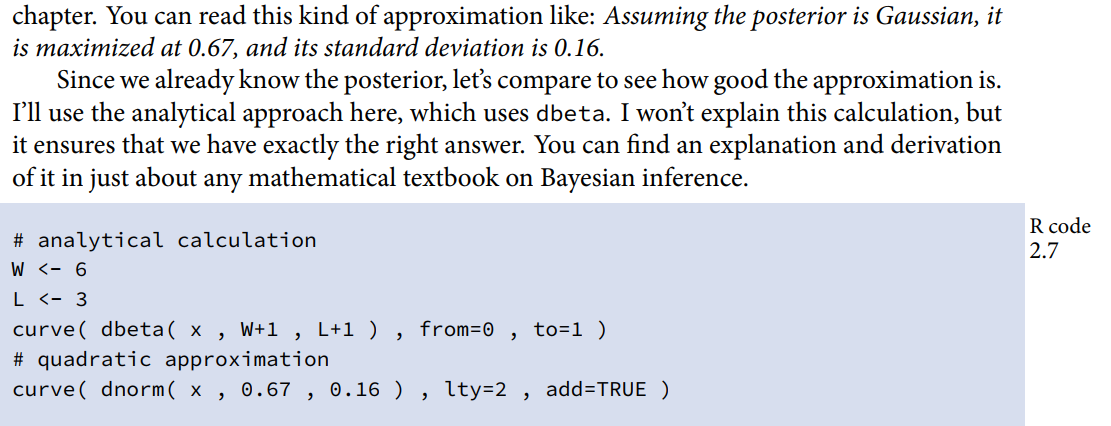

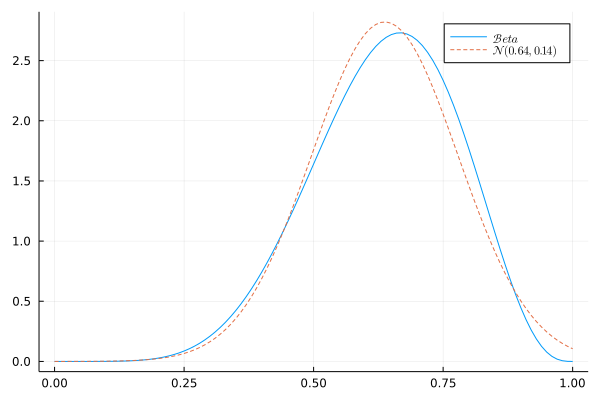

In [15]:
# analytical calculation
W = 6
L = 3
x = range(0, 1; length=101)

b = Beta(W+1, L+1)
plot(x, pdf.(b, x); label = L"\mathcal{Beta}")

# quadratic approximation
b = Normal(0.6374, 0.1414)
plot!(x, pdf.(b, x); style=:dash, label=L"\mathcal{N}(0.64, 0.14)")

# Code 2.8

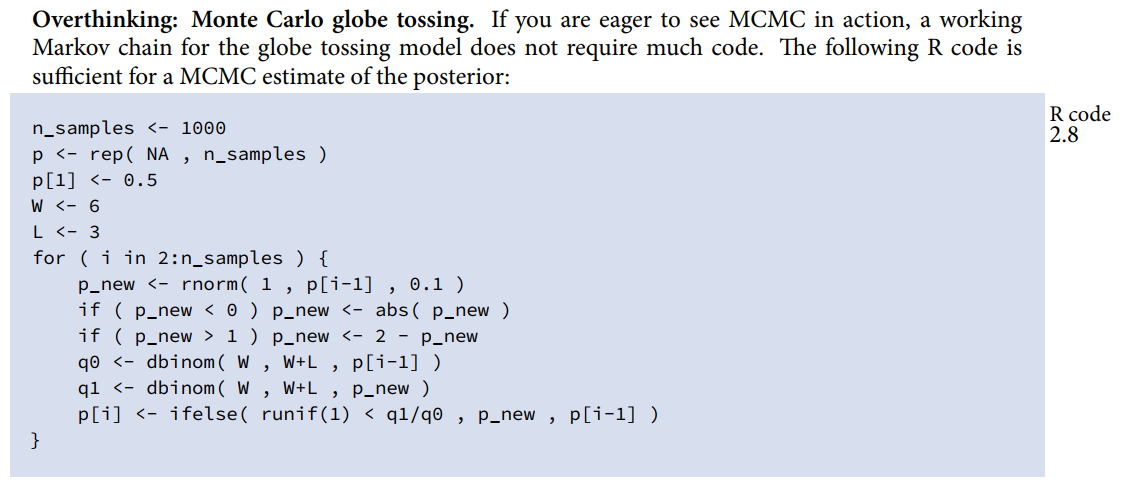

In [16]:
n_samples = 1000
p = Vector{Float64}(undef, n_samples)
p[1] = 0.5
W, L = 6, 3 #-------------------------

# MH
for i ∈ 2:n_samples
    p_old = p[i-1]
    p_new = rand(Normal(p_old, 0.1))
    if p_new < 0
        p_new = abs(p_new)
    elseif p_new > 1
        p_new = 2-p_new
    end

    q0 = pdf(Binomial(W+L, p_old), W)
    q1 = pdf(Binomial(W+L, p_new), W)
    u = rand(Uniform())
    p[i] = (u < q1 / q0) ? p_new : p_old    #  log exp,,,,to optmize
end

# Code 2.9

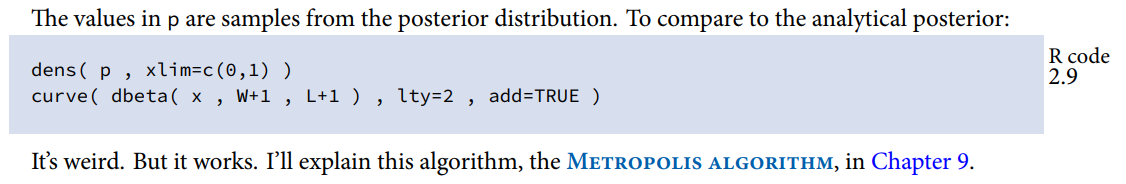

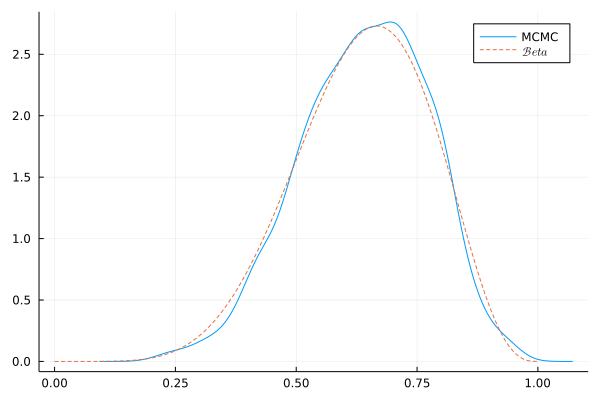

In [17]:
density(p; label = "MCMC")
b = Beta(W+1, L+1)
plot!(x, pdf.(b, x); label = L"\mathcal{Beta}", style=:dash)